## Classical RBM training on the Bars-And-Stripes Dataset for Reconstruction

Developed by: Jose Pinilla

In [1]:
# Required packages
import os
import qaml
import torch
SEED = 0
torch.manual_seed(SEED) # For deterministic weights

import matplotlib.pyplot as plt
import torchvision.transforms as torch_transforms

In [2]:
################################# Hyperparameters ##############################
M,N = SHAPE = (8,8)
DATA_SIZE = N*M
TRAIN, TEST = SPLIT = (360,150) #(8,8)
EPOCHS = 35
BATCH_SIZE = 64
SUBCLASSES = [1,2]

# Stochastic Gradient Descent
learning_rate = 0.1
weight_decay = 1e-4
momentum = 0.5

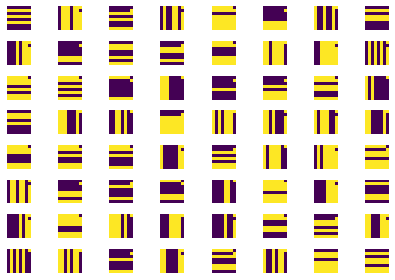

In [3]:
#################################### Input Data ################################
bas_dataset = qaml.datasets.BAS(*SHAPE,transform=qaml.datasets.ToSpinTensor())
set_label,get_label = qaml.datasets._embed_labels(bas_dataset,setter_getter=True)
train_dataset,test_dataset = torch.utils.data.random_split(bas_dataset,[*SPLIT])

train_sampler = torch.utils.data.RandomSampler(train_dataset,False)
train_loader = torch.utils.data.DataLoader(train_dataset,BATCH_SIZE,sampler=train_sampler)

test_sampler = torch.utils.data.RandomSampler(test_dataset,False)
test_loader = torch.utils.data.DataLoader(test_dataset,BATCH_SIZE,sampler=test_sampler)


# PLot all data
fig,axs = plt.subplots(8,8)
for img_batch,labels_batch in train_loader:
    for ax,img,label in zip(axs.flat,img_batch,labels_batch):
        ax.matshow(img.view(*SHAPE),vmin=0,vmax=1); ax.axis('off')
    break
plt.tight_layout()

In [ ]:
################################# Model Definition #############################
VISIBLE_SIZE = DATA_SIZE
HIDDEN_SIZE = 64

# Specify model with dimensions
rbm = qaml.nn.RBM(VISIBLE_SIZE, HIDDEN_SIZE, 'SPIN')

# Set up optimizer
optimizer = torch.optim.SGD(rbm.parameters(),lr=learning_rate,
                            weight_decay=weight_decay,
							momentum=momentum)

# Set up training mechanisms
CD = qaml.autograd.ContrastiveDivergence

In [5]:
# CD-k
pos_sampler = qaml.sampler.GibbsNetworkSampler(rbm,BATCH_SIZE)
neg_sampler = pos_sampler

In [6]:
# or PCD-k
NUM_CHAINS = 100
pos_sampler = qaml.sampler.GibbsNetworkSampler(rbm,BATCH_SIZE)
neg_sampler = qaml.sampler.GibbsNetworkSampler(rbm,NUM_CHAINS)

In [ ]:
################################## Model Training ##############################
K = 20 # CD-K or PCD-K
# Set the model to training mode
rbm.train()
p_log = []
r_log = []
err_log = []
score_log = []
kl_div_log = []
accuracy_log = []
for t in range(EPOCHS):
    kl_div = torch.Tensor([0.])
    epoch_error = torch.Tensor([0.])
    for img_batch,labels_batch in train_loader:
        input_data = img_batch.flatten(1)

        # Positive Phase
        v0, p_h0 = pos_sampler(input_data.detach(), k=0)

        # Negative Phase
        p_vk, p_hk = neg_sampler(v0.detach(),k=K) # CD-k
        # p_vk, p_hk = neg_sampler(k=K) # or PCD-k

        # Reconstruction error from Contrastive Divergence
        err = CD.apply(neg_sampler,(v0,p_h0),(p_vk,p_hk), *rbm.parameters())

        # Do not accumulate gradients
        optimizer.zero_grad()

        # Compute gradients
        err.backward()

        # Update parameters
        optimizer.step()

        #Accumulate error for this epoch
        epoch_error  += err
        vk = neg_sampler.sample(p_vk)
        kl_div += qaml.perf.free_energy_smooth_kl(rbm,v0,vk)

    # KL-Divergence
    kl_div_log.append(kl_div.item())
    print(f"Epoch {t} KL-Divergence = {kl_div.item()}")
    # Error Log
    err_log.append(epoch_error.item())
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")
    # BAS score
    precision, recall, score = bas_dataset.score(p_vk.bernoulli().view(-1,*SHAPE))
    p_log.append(precision); r_log.append(recall); score_log.append(score)
    print(f"Precision {precision:.2} Recall {recall:.2} Score {score:.2}")

    ############################# CLASSIFICATION ##################################
    count = 0
    for test_data, test_labels in test_loader:
        input_data = test_data.flatten(1)
        mask = set_label(torch.ones(1,*SHAPE),0).flatten()
        v_batch,h_batch = neg_sampler.reconstruct(input_data,mask=mask)
        for v_recon,v_test in zip(v_batch,test_data):
            label_pred = get_label(v_recon.view(1,*SHAPE))
            label_test = get_label(v_test.view(1,*SHAPE))
            if (torch.argmax(label_pred) == torch.argmax(label_test)):
                count+=1
    accuracy_log.append(count/len(test_dataset))
    print(f"Testing accuracy: {count}/{len(test_dataset)} ({count/len(test_dataset):.2f})")


Epoch 0 KL-Divergence = 34.47587966918945
Epoch 0 Reconstruction Error = 57.559776306152344
Precision 0.0 Recall 0.0 Score 0.0
Testing accuracy: 60/150 (0.40)
Epoch 1 KL-Divergence = 22.822364807128906
Epoch 1 Reconstruction Error = 44.264068603515625
Precision 0.075 Recall 0.0059 Score 0.011
Testing accuracy: 77/150 (0.51)
Epoch 2 KL-Divergence = 22.01764488220215
Epoch 2 Reconstruction Error = 44.823699951171875
Precision 0.025 Recall 0.002 Score 0.0036
Testing accuracy: 69/150 (0.46)
Epoch 3 KL-Divergence = 19.48187255859375
Epoch 3 Reconstruction Error = 33.509456634521484
Precision 0.05 Recall 0.0039 Score 0.0073
Testing accuracy: 63/150 (0.42)
Epoch 4 KL-Divergence = 10.14244556427002
Epoch 4 Reconstruction Error = 25.84229278564453
Precision 0.025 Recall 0.002 Score 0.0036
Testing accuracy: 68/150 (0.45)
Epoch 5 KL-Divergence = 12.49659538269043
Epoch 5 Reconstruction Error = 16.68234634399414
Precision 0.15 Recall 0.012 Score 0.022
Testing accuracy: 58/150 (0.39)
Epoch 6 KL-Div

In [8]:
############################ Store Model and Logs ##############################
directory = f"CD-{K}"

if not os.path.exists(f"./{directory}/{SEED}/"):
    os.makedirs(f"./{directory}/{SEED}/")

torch.save(p_log,f"./{directory}/{SEED}/p_log.pt")
torch.save(r_log,f"./{directory}/{SEED}/r_log.pt")
torch.save(err_log,f"./{directory}/{SEED}/err.pt")
torch.save(score_log,f"./{directory}/{SEED}/score_log.pt")
torch.save(kl_div_log,f"./{directory}/{SEED}/kl_div_log.pt")
torch.save(accuracy_log,f"./{directory}/{SEED}/accuracy.pt")

# Training Plots

Text(0.5, 0, 'Epoch')

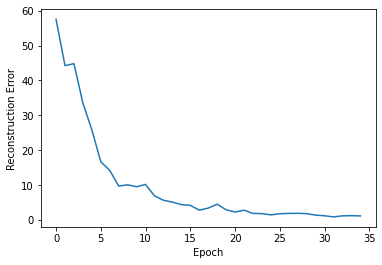

In [9]:
# L1 error graph
fig, ax = plt.subplots()
ax.plot(err_log)
plt.ylabel("Reconstruction Error")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

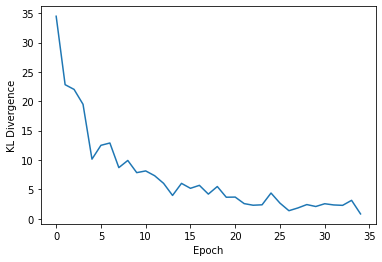

In [10]:
# KL Divergence graph
fig, ax = plt.subplots()
ax.plot(kl_div_log)
plt.ylabel("KL Divergence")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

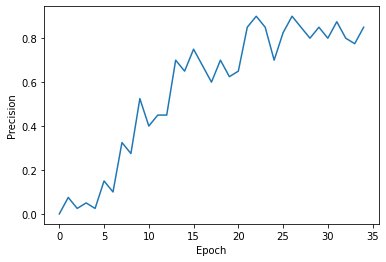

In [11]:
# Precision graph
fig, ax = plt.subplots()
ax.plot(p_log)
plt.ylabel("Precision")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

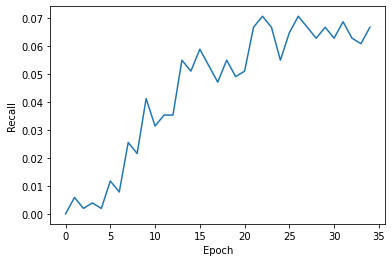

In [12]:
# Recall graph
fig, ax = plt.subplots()
ax.plot(r_log)
plt.ylabel("Recall")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

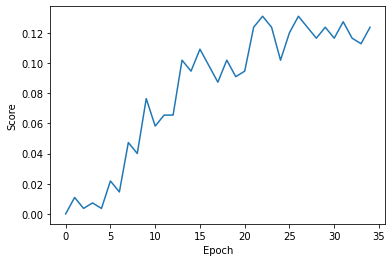

In [13]:
# Score graph
fig, ax = plt.subplots()
ax.plot(score_log)
plt.ylabel("Score")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

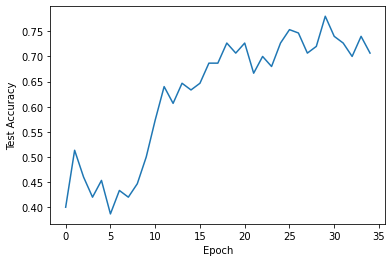

In [14]:
# Accuracy graph
fig, ax = plt.subplots()
ax.plot(accuracy_log)
plt.ylabel("Test Accuracy")
plt.xlabel("Epoch")

# Sampling

In [15]:
# Initialize 1000 sampling chains with random uniform probabilibites
num_samples = 1000
init = torch.FloatTensor(num_samples, VISIBLE_SIZE).uniform_(-1, +1)

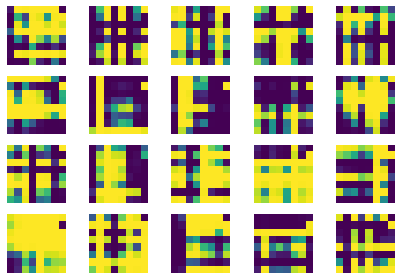

In [16]:
# Plot one forward pass
prob_v,_ = neg_sampler(init,k=1)
img_samples = prob_v.view(-1,*SHAPE)
# PLot some initialization values
fig,axs = plt.subplots(4,5)
for ax,img in zip(axs.flat,img_samples):
    ax.matshow(img.view(*SHAPE)); ax.axis('off')
plt.tight_layout()

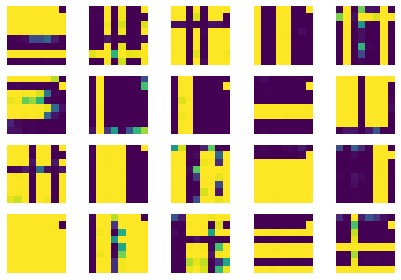

In [ ]:
# Plot samples after 1+5 forward passes
prob_v,_ = neg_sampler(k=5)
img_samples = prob_v.view(-1,*SHAPE)
# PLot some initialization values
fig,axs = plt.subplots(4,5)
for ax,img in zip(axs.flat,img_samples):
    ax.matshow(img.view(*SHAPE)); ax.axis('off')
plt.tight_layout()

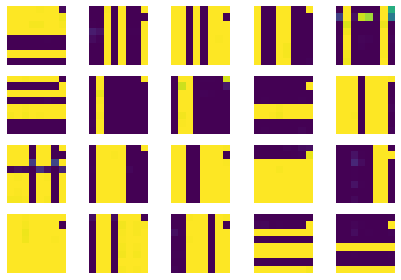

In [ ]:
# Plot samples after 1+5+10 forward passes (change k for higher Gibbs-k samples)
prob_v,_ = neg_sampler(k=10)
img_samples = prob_v.view(-1,*SHAPE)
# PLot some initialization values
fig,axs = plt.subplots(4,5)
for ax,img in zip(axs.flat,img_samples):
    ax.matshow(img.view(*SHAPE)); ax.axis('off')
plt.tight_layout()